In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, make_scorer, precision_score, recall_score, fbeta_score, matthews_corrcoef, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# --- 1. Loading the dataset ---
def load_dataset(file_path):
    """
    Loads a dataset from a specified file path.
    Assumes CSV format for simplicity.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully from {file_path}. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the dataset: {e}")
        return None

In [3]:
# --- 2. Perform EDA ---
def perform_eda(df, target_column):
    """
    Performs Exploratory Data Analysis including:
    a. Handling missing values
    b. Performing categorical encoding
    c. Performing outlier removal (using IQR)
    d. Standardizing/normalizing numerical features
    """
    print("\n--- Starting EDA ---")

    df_eda = df.copy()

    # Separate features and target
    X = df_eda.drop(columns=[target_column])
    y = df_eda[target_column]

    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    print(f"Numerical features: {numerical_features}")
    print(f"Categorical features: {categorical_features}")

    # a. Handle Missing Values
    print("\n--- Handling Missing Values ---")
    numerical_imputer = SimpleImputer(strategy='mean') # or 'median'
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    for col in numerical_features:
        if df_eda[col].isnull().sum() > 0:
            print(f"Imputing missing values in numerical column: {col}")
            df_eda[col] = numerical_imputer.fit_transform(df_eda[[col]])

    for col in categorical_features:
        if df_eda[col].isnull().sum() > 0:
            print(f"Imputing missing values in categorical column: {col}")
            df_eda[col] = categorical_imputer.fit_transform(df_eda[[col]])
    print("Missing value imputation complete.")


    # b. Perform Categorical Encoding (One-Hot Encoding)
    print("\n--- Performing Categorical Encoding ---")
    if categorical_features:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df_eda[categorical_features])
        encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features), index=df_eda.index)
        df_eda = pd.concat([df_eda.drop(columns=categorical_features), encoded_df], axis=1)
        print("Categorical encoding complete using OneHotEncoder.")
    else:
        print("No categorical features found for encoding.")


    '''# c. Perform Outlier Removal (using IQR method)
    print("\n--- Performing Outlier Removal (IQR method) ---")
    original_shape = df_eda.shape[0]
    for col in numerical_features:
        Q1 = df_eda[col].quantile(0.25)
        Q3 = df_eda[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_eda = df_eda[(df_eda[col] >= lower_bound) & (df_eda[col] <= upper_bound)]
    new_shape = df_eda.shape[0]
    print(f"Outlier removal complete. Removed {original_shape - new_shape} rows.")'''


    # d. Standardize/Normalize numerical features
    print("\n--- Standardizing Numerical Features ---")
    # Re-identify numerical features after encoding (new encoded columns are numerical)
    numerical_features_after_encoding = df_eda.select_dtypes(include=np.number).columns.tolist()
    # Exclude the target column if it's numerical and we haven't dropped it yet
    if target_column in numerical_features_after_encoding:
        numerical_features_after_encoding.remove(target_column)

    scaler = StandardScaler() # Or MinMaxScaler()
    df_eda[numerical_features_after_encoding] = scaler.fit_transform(df_eda[numerical_features_after_encoding])
    print("Numerical features standardized using StandardScaler.")

    '''# d. Normalize numerical features
    print("\n--- Normalizing Numerical Features ---")
    # Re-identify numerical features after encoding (new encoded columns are numerical)
    numerical_features_after_encoding = df_eda.select_dtypes(include=np.number).columns.tolist()
    # Exclude the target column if it's numerical and we haven't dropped it yet
    if target_column in numerical_features_after_encoding:
        numerical_features_after_encoding.remove(target_column)

    scaler = MinMaxScaler()  # Normalization scales data to [0, 1] range
    df_eda[numerical_features_after_encoding] = scaler.fit_transform(df_eda[numerical_features_after_encoding])
    print("Numerical features normalized using MinMaxScaler.")'''


    print("\n--- EDA Complete ---")
    return df_eda, target_column # Return the processed DataFrame and target column name


In [4]:
# --- 3. Splitting the dataset ---
def split_dataset(df, target_column, test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets.
    """
    print("\n--- Splitting Dataset ---")
    X = df.drop(columns=[target_column])


    y = df[target_column]
    print(y.value_counts())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    print(f"Dataset split: X_train shape {X_train.shape}, X_test shape {X_test.shape}")
    print(f"y_train shape {y_train.shape}, y_test shape {y_test.shape}")
    return X_train, X_test, y_train, y_test

In [9]:
# --- 4. Model Defining ---
def define_model(model_type='LogisticRegression',k=1):
    """
    Defines and returns a machine learning model.
    Can be extended to include other models.
    """
    print("\n--- Defining Model ---")
    if model_type == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(random_state=42, solver='liblinear')
    elif model_type=='GaussianNB':
        from sklearn.naive_bayes import GaussianNB
        model = GaussianNB()
    elif model_type=='BernoulliNB':
        from sklearn.naive_bayes import BernoulliNB
        model = BernoulliNB()
    elif model_type=='MultinomialNB':
        from sklearn.naive_bayes import MultinomialNB
        model = MultinomialNB()
    elif model_type=='KNN':
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=k)
    elif model_type=='KNN_BallTree':
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=k,algorithm='ball_tree')
    elif model_type=='KNN_KDTree':
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    elif model_type == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'SVCLinear':
        from sklearn.svm import SVC
        model = SVC(kernel='linear', C=1.0, random_state=42) # probability=True for ROC curve
    elif model_type == 'SVCPoly':
        from sklearn.svm import SVC
        model = SVC(kernel='poly',degree=3, C=1.0, random_state=42)
    elif model_type == 'SVCRbf':
        from sklearn.svm import SVC
        model = SVC(kernel='rbf', C=1.0, random_state=42)
    elif model_type == 'SVCSigmoid':
        from sklearn.svm import SVC
        model = SVC(kernel='sigmoid', C=1.0, random_state=42)
    else:
        raise ValueError(f"Model type '{model_type}' not supported. Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'.")
    print(f"Model defined: {model_type}")
    return model

In [6]:
def performance_analysis(model, X_train, y_train, X_test, y_test):
    """
    Performs model training and comprehensive performance analysis including:
    a. Confusion Matrix
    b. ROC curve
    c. Cross-validation for Accuracy, Precision, Recall, F-Beta score, MCC
       Prints cross-validation results as a table for all 5 folds.
    """
    print("\n--- Performing Performance Analysis ---")
    import time
    # Train the model
    start_kd = time.time()
    model.fit(X_train, y_train)
    end_kd = time.time()
    kd_train_time = end_kd - start_kd
    print(f"training time: {kd_train_time:.6f} seconds")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # a. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # b. ROC Curve
    print("\n--- ROC Curve ---")
    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print("Model does not have 'predict_proba' method. Cannot plot ROC curve.")

    # Cross-validation for 5 metrics
    print("\n--- Cross-Validation (5-Fold) ---")
    cv_results_df = pd.DataFrame() # DataFrame to store all fold scores

    scoring_metrics = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='binary', zero_division=0),
        'recall': make_scorer(recall_score, average='binary', zero_division=0),
        'fbeta_score': make_scorer(fbeta_score, beta=1, average='binary', zero_division=0), # F1-score as default, can change beta
        'mcc': make_scorer(matthews_corrcoef)
    }

    # Combine X_train and y_train for cross_val_score
    X_combined = pd.concat([X_train, X_test])
    y_combined = pd.concat([y_train, y_test])

    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X_combined, y_combined, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scorer)
        cv_results_df[metric_name.replace('_', ' ').title()] = scores # Add scores to DataFrame

    # Add Mean and Std Dev rows
    mean_row = cv_results_df.mean().to_frame().T
    mean_row.index = ['Mean']
    std_row = cv_results_df.std().to_frame().T
    std_row.index = ['Std Dev']

    # Combine all into one table for printing
    cv_table = pd.concat([cv_results_df, mean_row, std_row])
    cv_table.index.name = 'Fold/Summary'
    cv_table.columns.name = 'Metric'

    print("\n--- Cross-Validation Results (5 Folds) ---")
    print(cv_table.round(4).to_string()) # Use to_string() to print full DataFrame without truncation

    print("\n--- Performance Analysis Complete ---")
    return cv_table# Return the DataFrame for further use if needed

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

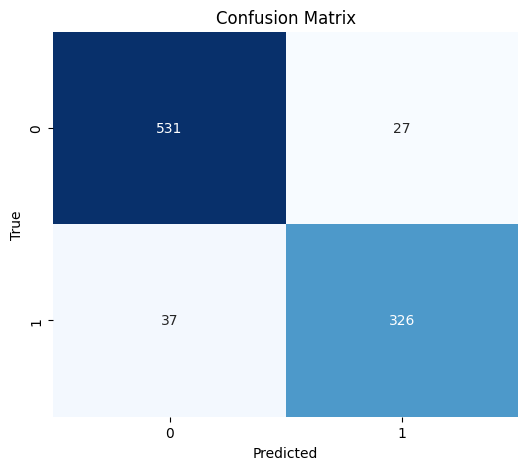


--- ROC Curve ---
Model does not have 'predict_proba' method. Cannot plot ROC curve.

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.9283     0.9207  0.8953       0.9078  0.8494
1               0.9413     0.9451  0.9033       0.9237  0.8767
2               0.9250     0.9150  0.8923       0.9035  0.8424
3               0.9326     0.9263  0.9008       0.9134  0.8585
4               0.9174     0.9112  0.8760       0.8933  0.8263
Mean            0.9289     0.9237  0.8936       0.9083  0.8507
Std Dev         0.0089     0.0133  0.0107       0.0113  0.0187

--- Performance Analysis Complete ---
Accuracy: 0.929
Precision: 0.924
Recall: 0.894
Fbeta Score: 0.908
Mcc: 0.851


In [10]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'SVCLinear' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

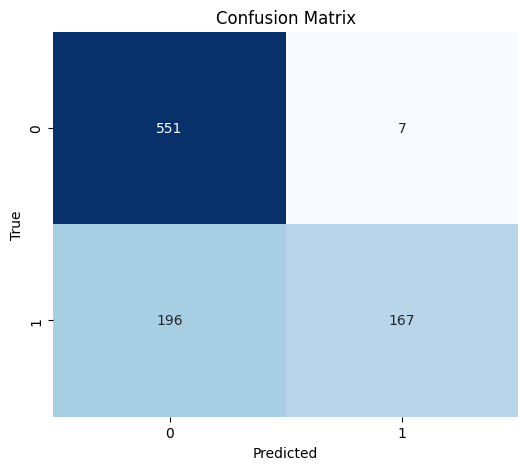


--- ROC Curve ---
Model does not have 'predict_proba' method. Cannot plot ROC curve.

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.7752     0.9432  0.4573       0.6160  0.5461
1               0.7717     0.9524  0.4420       0.6038  0.5408
2               0.7891     0.9516  0.4890       0.6460  0.5751
3               0.7663     0.9512  0.4298       0.5920  0.5305
4               0.7837     0.9316  0.4876       0.6401  0.5605
Mean            0.7772     0.9460  0.4611       0.6196  0.5506
Std Dev         0.0092     0.0089  0.0266       0.0231  0.0175

--- Performance Analysis Complete ---
Accuracy: 0.777
Precision: 0.946
Recall: 0.461
Fbeta Score: 0.62
Mcc: 0.551


In [11]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'SVCPoly' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

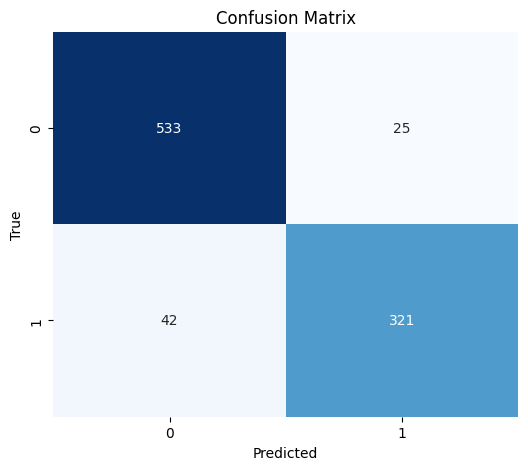


--- ROC Curve ---
Model does not have 'predict_proba' method. Cannot plot ROC curve.

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.9273     0.9277  0.8843       0.9055  0.8471
1               0.9337     0.9413  0.8867       0.9132  0.8607
2               0.9315     0.9284  0.8950       0.9114  0.8560
3               0.9424     0.9403  0.9118       0.9259  0.8791
4               0.9337     0.9339  0.8953       0.9142  0.8607
Mean            0.9337     0.9343  0.8946       0.9140  0.8607
Std Dev         0.0055     0.0064  0.0108       0.0074  0.0117

--- Performance Analysis Complete ---
Accuracy: 0.934
Precision: 0.934
Recall: 0.895
Fbeta Score: 0.914
Mcc: 0.861


In [12]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'SVCRbf' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

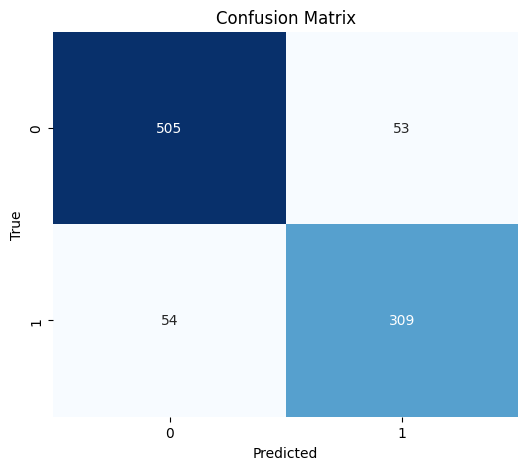


--- ROC Curve ---
Model does not have 'predict_proba' method. Cannot plot ROC curve.

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.8795     0.8559  0.8347       0.8452  0.7467
1               0.8804     0.8500  0.8453       0.8476  0.7493
2               0.8783     0.8492  0.8398       0.8444  0.7445
3               0.8793     0.8728  0.8127       0.8417  0.7456
4               0.8772     0.8551  0.8292       0.8420  0.7418
Mean            0.8789     0.8566  0.8323       0.8442  0.7456
Std Dev         0.0013     0.0095  0.0125       0.0025  0.0028

--- Performance Analysis Complete ---
Accuracy: 0.879
Precision: 0.857
Recall: 0.832
Fbeta Score: 0.844
Mcc: 0.746


In [13]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'SVCSigmoid' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

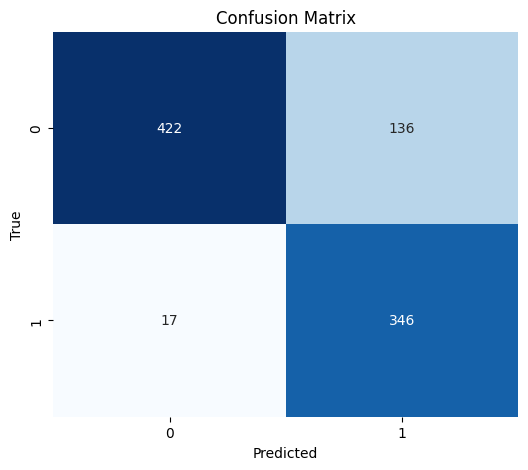


--- ROC Curve ---


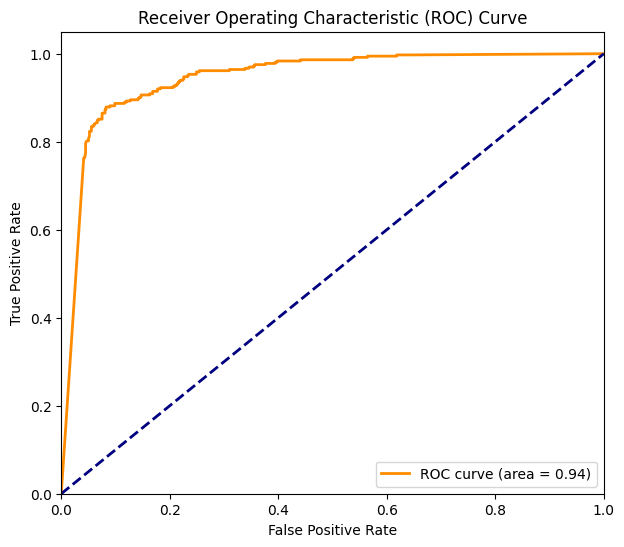

ROC AUC: 0.9449

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.8241     0.7039  0.9559       0.8107  0.6802
1               0.8185     0.6970  0.9530       0.8051  0.6705
2               0.8250     0.7072  0.9475       0.8099  0.6781
3               0.8185     0.6952  0.9614       0.8069  0.6741
4               0.8141     0.6897  0.9614       0.8032  0.6676
Mean            0.8200     0.6986  0.9559       0.8072  0.6741
Std Dev         0.0045     0.0070  0.0059       0.0032  0.0052

--- Performance Analysis Complete ---
Accuracy: 0.82
Precision: 0.699
Recall: 0.956
Fbeta Score: 0.807
Mcc: 0.674


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'GaussianNB' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Splitting Dataset ---
class
0    2788
1    1813
Name: count, dtype: int64
Dataset split: X_train shape (3680, 57), X_test shape (921, 57)
y_train shape (3680,), y_test shape (921,)

--- Defining Model ---
Model defined: MultinomialNB

--- Performing Performance Analysis ---

--- Confusion Matrix ---
[[458 100]
 [106 257]]


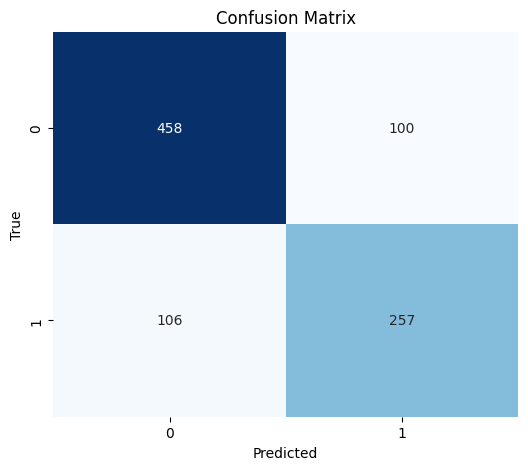


--- ROC Curve ---


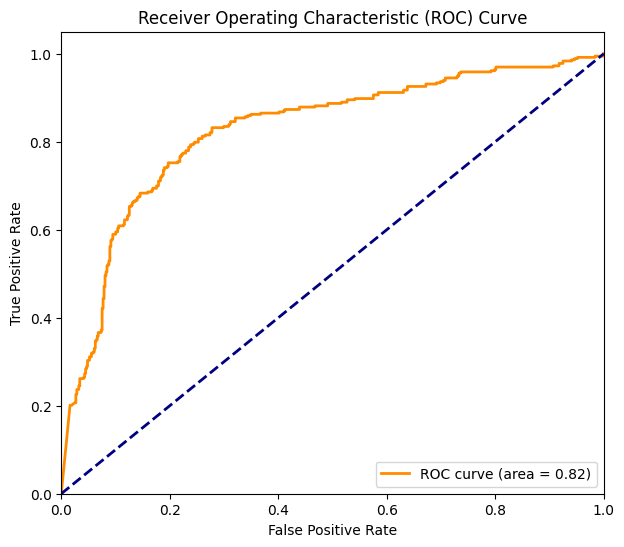

ROC AUC: 0.8248

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.7752     0.7254  0.6915       0.7080  0.5259
1               0.7967     0.7628  0.7017       0.7309  0.5694
2               0.8054     0.7493  0.7597       0.7545  0.5934
3               0.8163     0.7500  0.8017       0.7750  0.6211
4               0.7598     0.7088  0.6639       0.6856  0.4923
Mean            0.7907     0.7393  0.7237       0.7308  0.5604
Std Dev         0.0229     0.0217  0.0558       0.0356  0.0517

--- Performance Analysis Complete ---
Accuracy: 0.791
Precision: 0.739
Recall: 0.724
Fbeta Score: 0.731
Mcc: 0.56


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'MultinomialNB' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")



        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(df, TARGET_COLUMN)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

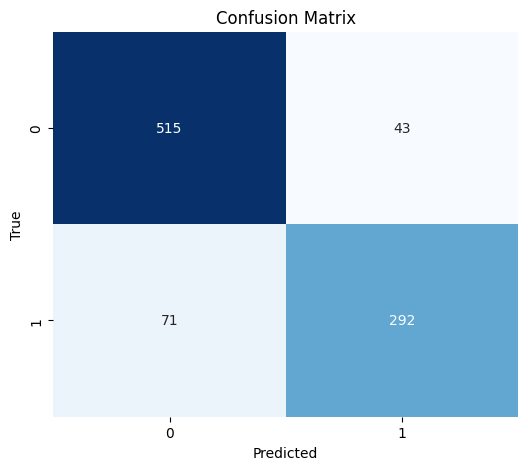


--- ROC Curve ---


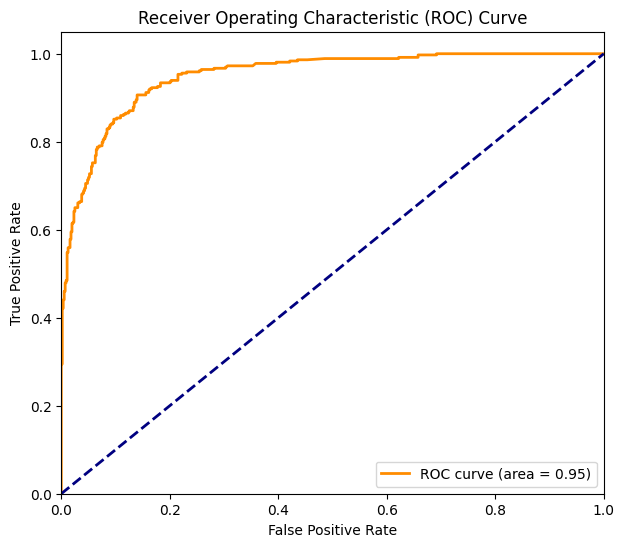

ROC AUC: 0.9496

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.8914     0.8879  0.8292       0.8575  0.7712
1               0.8859     0.8836  0.8177       0.8494  0.7592
2               0.8870     0.9006  0.8011       0.8480  0.7618
3               0.8891     0.8991  0.8099       0.8522  0.7665
4               0.8826     0.8696  0.8264       0.8475  0.7528
Mean            0.8872     0.8882  0.8169       0.8509  0.7623
Std Dev         0.0033     0.0127  0.0116       0.0041  0.0070

--- Performance Analysis Complete ---
Accuracy: 0.887
Precision: 0.888
Recall: 0.817
Fbeta Score: 0.851
Mcc: 0.762


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'BernoulliNB' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

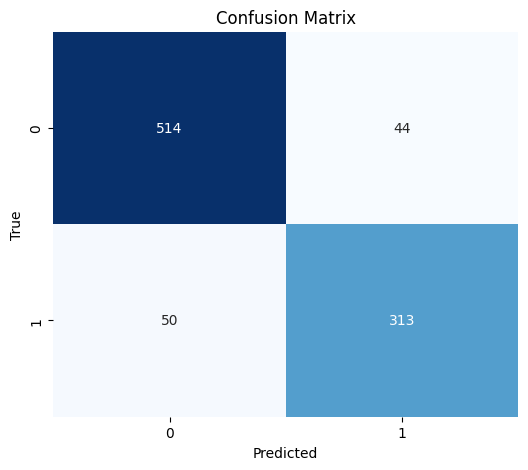


--- ROC Curve ---


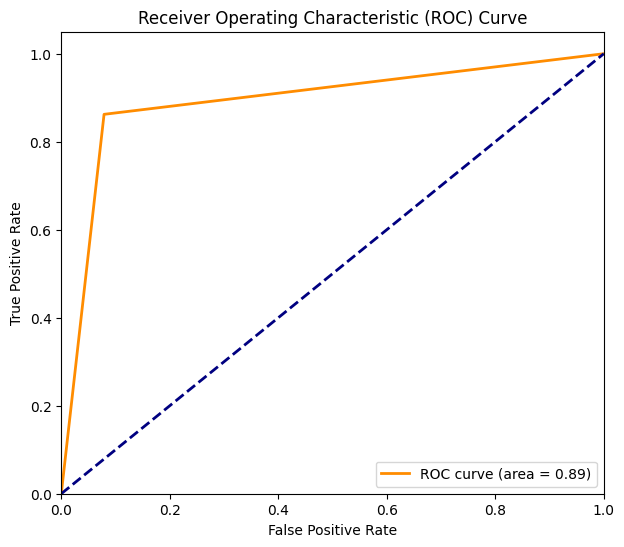

ROC AUC: 0.8917

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.9131     0.8920  0.8871       0.8895  0.8180
1               0.9076     0.8991  0.8619       0.8801  0.8055
2               0.9065     0.8791  0.8840       0.8815  0.8044
3               0.9272     0.8978  0.9201       0.9088  0.8484
4               0.9065     0.8837  0.8788       0.8812  0.8042
Mean            0.9122     0.8903  0.8864       0.8882  0.8161
Std Dev         0.0088     0.0088  0.0212       0.0121  0.0190

--- Performance Analysis Complete ---
Accuracy: 0.912
Precision: 0.89
Recall: 0.886
Fbeta Score: 0.888
Mcc: 0.816


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'KNN' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE,1)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

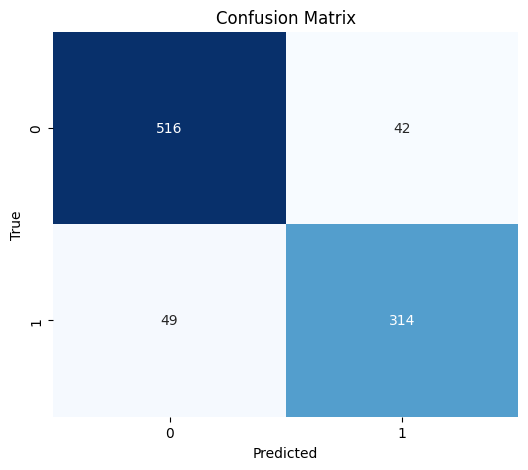


--- ROC Curve ---


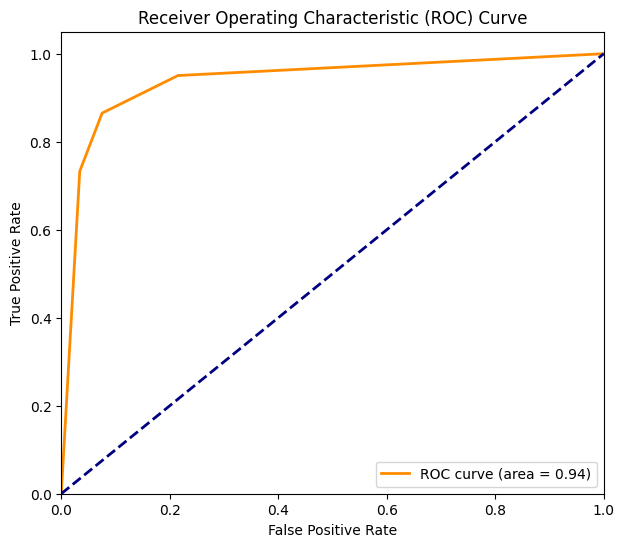

ROC AUC: 0.9378

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.9186     0.9022  0.8898       0.8960  0.8291
1               0.9033     0.8867  0.8646       0.8755  0.7966
2               0.9076     0.8837  0.8812       0.8824  0.8063
3               0.9207     0.8984  0.9008       0.8996  0.8340
4               0.9033     0.8892  0.8623       0.8755  0.7967
Mean            0.9107     0.8920  0.8797       0.8858  0.8126
Std Dev         0.0084     0.0079  0.0164       0.0114  0.0179

--- Performance Analysis Complete ---
Accuracy: 0.911
Precision: 0.892
Recall: 0.88
Fbeta Score: 0.886
Mcc: 0.813


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'KNN' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE,3)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

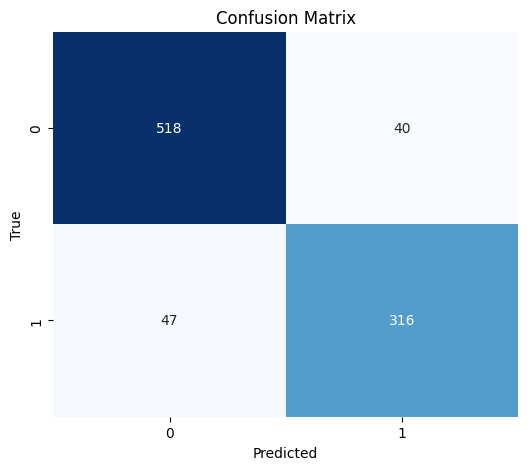


--- ROC Curve ---


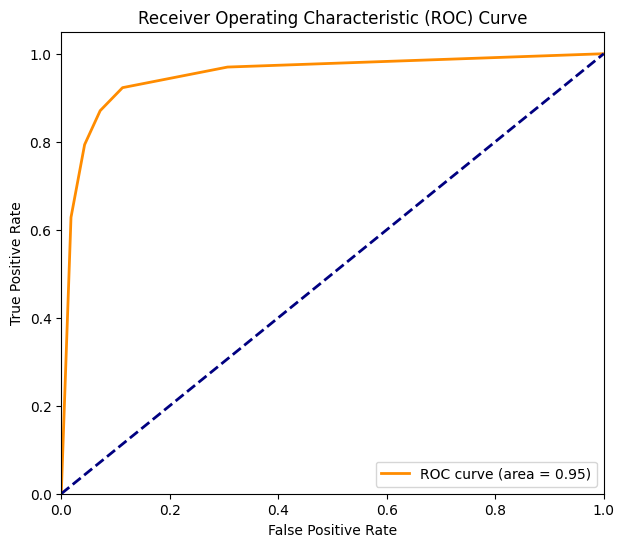

ROC AUC: 0.9505

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.9121     0.9006  0.8733       0.8867  0.8151
1               0.9076     0.8991  0.8619       0.8801  0.8055
2               0.9087     0.8840  0.8840       0.8840  0.8087
3               0.9120     0.9006  0.8733       0.8867  0.8150
4               0.9000     0.8883  0.8540       0.8708  0.7897
Mean            0.9081     0.8945  0.8693       0.8817  0.8068
Std Dev         0.0049     0.0078  0.0116       0.0067  0.0104

--- Performance Analysis Complete ---
Accuracy: 0.908
Precision: 0.895
Recall: 0.869
Fbeta Score: 0.882
Mcc: 0.807


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'KNN' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE,5)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

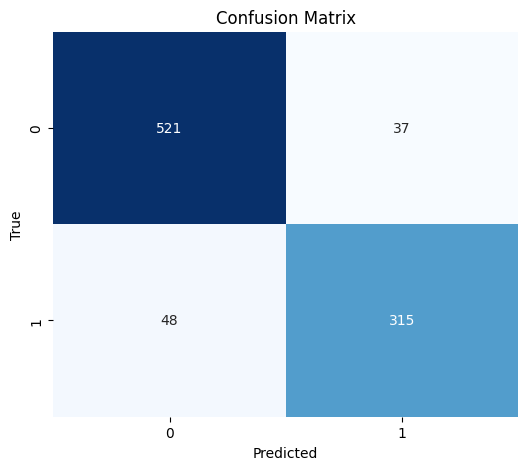


--- ROC Curve ---


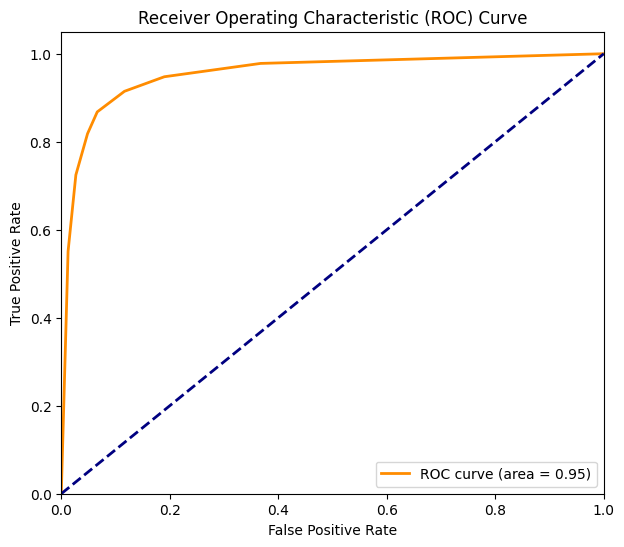

ROC AUC: 0.9539

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.9055     0.8943  0.8623       0.8780  0.8013
1               0.9076     0.9134  0.8453       0.8780  0.8054
2               0.9043     0.8827  0.8729       0.8778  0.7992
3               0.9098     0.8977  0.8705       0.8839  0.8104
4               0.8946     0.8912  0.8347       0.8620  0.7779
Mean            0.9044     0.8959  0.8571       0.8759  0.7989
Std Dev         0.0059     0.0113  0.0166       0.0082  0.0125

--- Performance Analysis Complete ---
Accuracy: 0.904
Precision: 0.896
Recall: 0.857
Fbeta Score: 0.876
Mcc: 0.799


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'KNN' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE,7)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

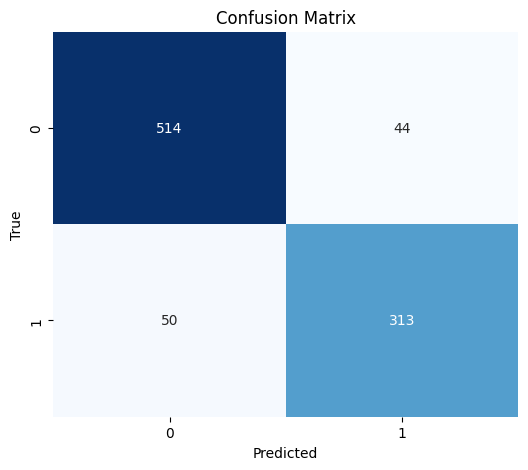


--- ROC Curve ---


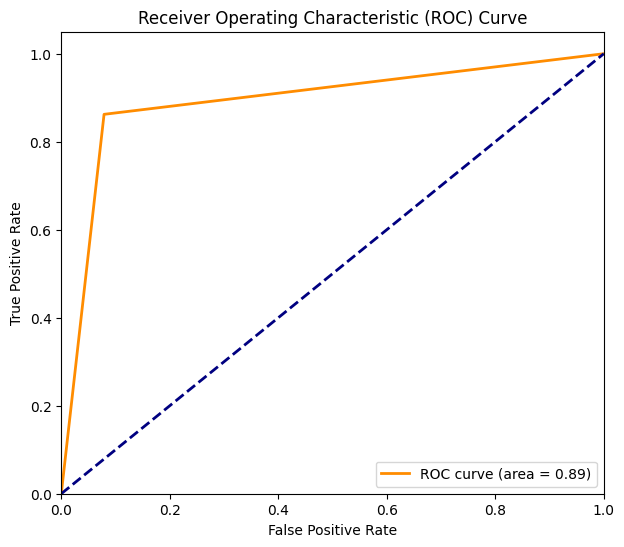

ROC AUC: 0.8917

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.9131     0.8920  0.8871       0.8895  0.8180
1               0.9076     0.8991  0.8619       0.8801  0.8055
2               0.9065     0.8791  0.8840       0.8815  0.8044
3               0.9272     0.8978  0.9201       0.9088  0.8484
4               0.9065     0.8837  0.8788       0.8812  0.8042
Mean            0.9122     0.8903  0.8864       0.8882  0.8161
Std Dev         0.0088     0.0088  0.0212       0.0121  0.0190

--- Performance Analysis Complete ---
Accuracy: 0.912
Precision: 0.89
Recall: 0.886
Fbeta Score: 0.888
Mcc: 0.816


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'KNN_BallTree' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE,1)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

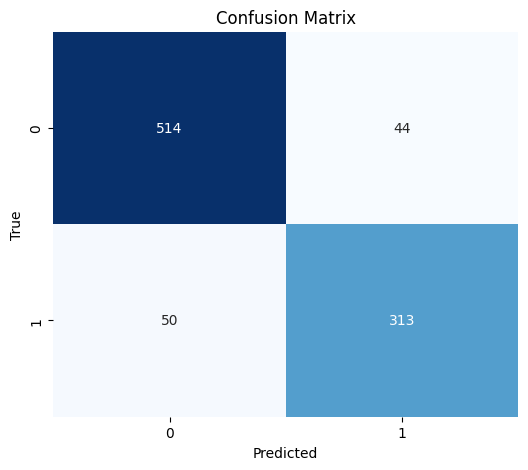


--- ROC Curve ---


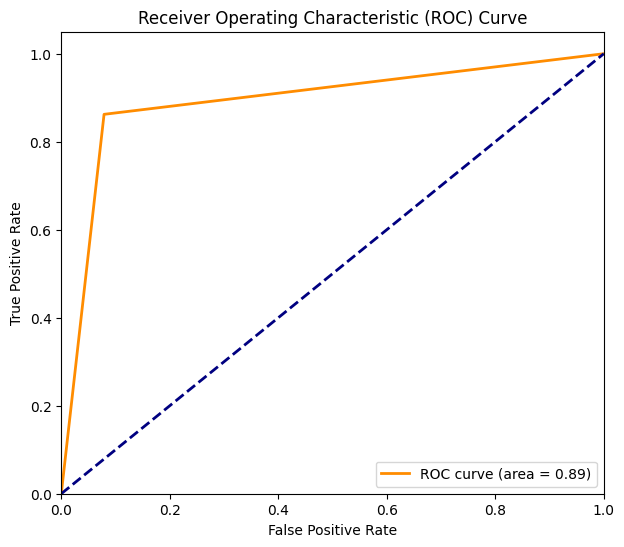

ROC AUC: 0.8917

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
Metric        Accuracy  Precision  Recall  Fbeta Score     Mcc
Fold/Summary                                                  
0               0.9131     0.8920  0.8871       0.8895  0.8180
1               0.9076     0.8991  0.8619       0.8801  0.8055
2               0.9054     0.8788  0.8812       0.8800  0.8020
3               0.9272     0.8978  0.9201       0.9088  0.8484
4               0.9065     0.8837  0.8788       0.8812  0.8042
Mean            0.9120     0.8903  0.8858       0.8879  0.8156
Std Dev         0.0090     0.0089  0.0213       0.0123  0.0194

--- Performance Analysis Complete ---
Accuracy: 0.912
Precision: 0.89
Recall: 0.886
Fbeta Score: 0.888
Mcc: 0.816


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'KNN_KDTree' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE,1)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

In [ ]:
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'spambase_csv.csv' # Replace with your dataset path
    TARGET_COLUMN = 'class' # Replace with your target column name
    MODEL_TYPE = 'KNN' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'

    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")

   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE,1)
        param_grid = {
          'n_neighbors': list(range(1, 31)),              # Try k from 1 to 30
          'weights': ['uniform', 'distance'],             # Uniform or distance-weighted
          'metric': ['euclidean', 'manhattan'],           # Distance metrics
          'algorithm': ['auto', 'ball_tree', 'kd_tree']   # Tree types
      }
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

        # Step 4: Fit on training data
        grid_search.fit(X_train, y_train)

        # Step 5: Best parameters and score
        print("Best Parameters:", grid_search.best_params_)
        print("Best Accuracy:", grid_search.best_score_)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','Fbeta Score'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','Mcc'],3))

Dataset loaded successfully from spambase_csv.csv. Shape: (4601, 58)

--- Starting EDA ---
Numerical features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq

NameError: name 'knn' is not defined